# Сверточная нейронная сеть

Mounted at /content/drive
Using device: cpu


Epoch [1/20], Train Loss: 0.1801, Val Loss: 0.1010


Epoch [2/20], Train Loss: 0.0869, Val Loss: 0.0788


Epoch [3/20], Train Loss: 0.0692, Val Loss: 0.0623


Epoch [4/20], Train Loss: 0.0579, Val Loss: 0.0552


Epoch [5/20], Train Loss: 0.0525, Val Loss: 0.0506


Epoch [6/20], Train Loss: 0.0488, Val Loss: 0.0474


Epoch [7/20], Train Loss: 0.0457, Val Loss: 0.0452


Epoch [8/20], Train Loss: 0.0433, Val Loss: 0.0433


Epoch [9/20], Train Loss: 0.0415, Val Loss: 0.0410


Epoch [10/20], Train Loss: 0.0401, Val Loss: 0.0406


Epoch [11/20], Train Loss: 0.0389, Val Loss: 0.0398


Epoch [12/20], Train Loss: 0.0379, Val Loss: 0.0380


Epoch [13/20], Train Loss: 0.0370, Val Loss: 0.0370


Epoch [14/20], Train Loss: 0.0363, Val Loss: 0.0367


Epoch [15/20], Train Loss: 0.0354, Val Loss: 0.0364


Epoch [16/20], Train Loss: 0.0350, Val Loss: 0.0357


Epoch [17/20], Train Loss: 0.0342, Val Loss: 0.0350


Epoch [18/20], Train Loss: 0.0337, Val Loss: 0.0346


Epoch [19/20], Train Loss: 0.0333, Val Loss: 0.0341


Epoch [20/20], Train Loss: 0.0329, Val Loss: 0.0335
Finished Training


Test Loss: 0.0335


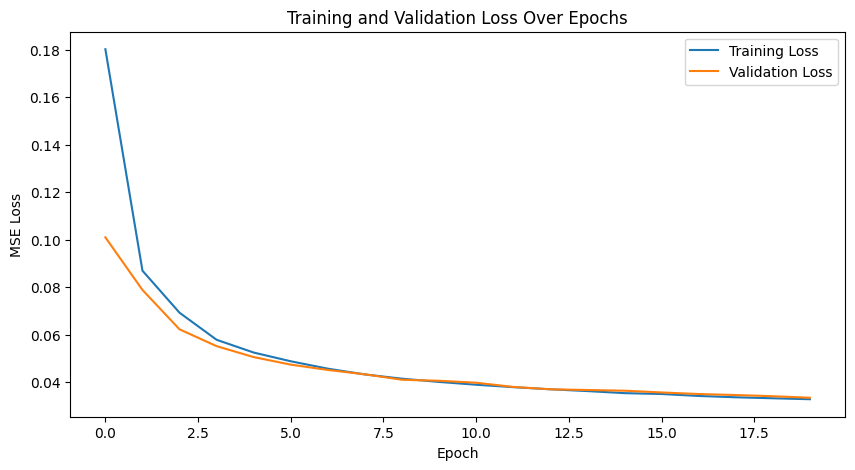

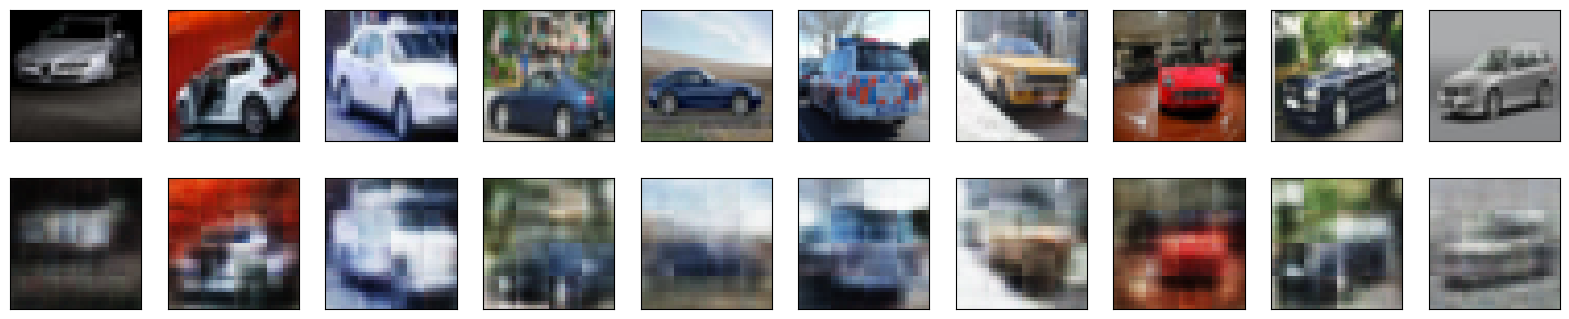


System Information:
  Python Version: 3.11.13
  PyTorch Version: 2.6.0+cu124
  Device: cpu
  Operating System: Linux 6.1.123+
  CPU: x86_64

Model Summary:
  Total parameters: 134691
  Trainable parameters: 134691


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import platform
from google.colab import drive

# Монтируем Google Drive
drive.mount('/content/drive')

# Определяем устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Гиперпараметры
batch_size = 64
learning_rate = 0.001
num_epochs = 20  # Увеличено количество эпох
validation_split = 0.2  # Доля данных для валидации

# Пути к данным
train_path = '/content/drive/MyDrive/ML_Project/Automobile_train'  # Путь к тренировочным данным
test_path = '/content/drive/MyDrive/ML_Project/automobile_test'    # Путь к тестовым данным

# Проверяем, что папка с данными существует
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Train directory not found: {train_path}")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test directory not found: {test_path}")

# Кастомный датасет для загрузки изображений из подпапок
class AutomobileDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Проходим по всем подпапкам и собираем пути к изображениям
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith('.png'):  # Загружаем только .png изображения
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(class_name)  # Метка — это имя папки

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Открываем изображение и конвертируем в RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, image  # Для автоэнкодера вход и цель — одно и то же изображение

# Трансформации
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Изменяем размер изображений до 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

# Загрузка тренировочного и тестового датасетов
train_dataset = AutomobileDataset(root_dir=train_path, transform=transform)
test_dataset = AutomobileDataset(root_dir=test_path, transform=transform)

# Разделение тренировочного датасета на тренировочные и валидационные данные
train_size = int((1 - validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader для тренировочных, валидационных и тестовых данных
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)  # Уменьшено количество workers
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)  # Уменьшено количество workers
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)  # Уменьшено количество workers

# Определение модели автоэнкодера
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 16x16x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 16x16x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 8x8x64
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Добавлен новый слой
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # Output: 4x4x128
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # Output: 8x8x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Output: 16x16x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),   # Output: 32x32x3
            nn.Tanh()  # Выходные значения в диапазоне [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Создание модели и перемещение на GPU
model = Autoencoder().to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()  # Среднеквадратичная ошибка
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2-регуляризация

# Хранение значений потерь для построения графиков
train_loss_history = []
val_loss_history = []

# Цикл обучения с валидацией
for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим обучения

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    train_epoch_loss = 0.0  # Инициализация потерь для эпохи
    for data in train_loop:
        img, _ = data
        img = img.to(device)

        # Прямой проход
        output = model(img)
        loss = criterion(output, img)

        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item() * img.size(0)  # Накопление потерь
        train_loop.set_postfix(loss=loss.item())

    # Вычисление средних потерь для эпохи
    train_epoch_loss /= len(train_dataset)
    train_loss_history.append(train_epoch_loss)

    # Валидация
    model.eval()  # Переводим модель в режим оценки
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    val_epoch_loss = 0.0  # Инициализация потерь для валидации
    with torch.no_grad():  # Отключаем расчет градиентов
        for data in val_loop:
            img, _ = data
            img = img.to(device)

            # Прямой проход
            output = model(img)
            loss = criterion(output, img)

            val_epoch_loss += loss.item() * img.size(0)  # Накопление потерь
            val_loop.set_postfix(loss=loss.item())

    # Вычисление средних потерь для валидации
    val_epoch_loss /= len(val_dataset)
    val_loss_history.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

print("Finished Training")

# Оценка модели на тестовых данных
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        test_loss += loss.item() * img.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Визуализация оригинальных и восстановленных изображений
model.eval()  # Переводим модель в режим оценки

# Создаем списки для хранения оригинальных и восстановленных изображений
original_images = []
reconstructed_images = []

# Проходим по всему тестовому датасету
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)

        # Сохраняем оригинальные и восстановленные изображения
        original_images.append(img.cpu())
        reconstructed_images.append(output.cpu())

# Преобразуем списки в тензоры
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Отображаем первые N изображений
n = 10  # Количество изображений для отображения
plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригинальные изображения
    ax = plt.subplot(2, n, i + 1)
    img = original_images[i].permute(1, 2, 0).numpy()
    img = (img + 1) / 2  # Де-нормализация
    plt.imshow(img.clip(0, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Восстановленные изображения
    ax = plt.subplot(2, n, i + 1 + n)
    img = reconstructed_images[i].permute(1, 2, 0).numpy()
    img = (img + 1) / 2  # Де-нормализация
    plt.imshow(img.clip(0, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Вывод системной информации
print("\nSystem Information:")
print(f"  Python Version: {platform.python_version()}")
print(f"  PyTorch Version: {torch.__version__}")
print(f"  Device: {device}")
if device == "cuda":
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
print(f"  Operating System: {platform.system()} {platform.release()}")
print(f"  CPU: {platform.processor()}")

# Вывод сводки модели
print("\nModel Summary:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")

In [ ]:
from torchsummary import summary
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
  ConvTranspose2d-10             [-1, 64, 8, 8]          32,832
             ReLU-11             [-1, 64, 8, 8]               0
  ConvTranspose2d-12           [-1, 32, 16, 16]           8,224
             ReLU-13           [-1, 32, 16, 16]               0
  ConvTranspose2d-14            [-1, 3,